# Data quality analysis

My goal for this project is to explore the Wikipedia clickstream datasets using network analyis. The first step towards that goal is to perform data quality analysis, which involves looking at the raw data, understanding its structure, and finding any anomalies in the raw data. 

### Data sources

[This is the Wikipedia clickstream datasets dump](https://dumps.wikimedia.org/other/clickstream/). It contains monthly Wikipedia clickstream data dumps for a selection top Wikipedia languages. The earliest datasets available are for November 2011, for the following 5 languages: German, English, Spanish, Japanese and Russian. In 2018, the list of languages has expanded to 11.

#### Let's make a list of all available Wikipedia clickstream datasets, as of January 2019.


In [75]:
from bs4 import BeautifulSoup

In [74]:
!ls -lah ../data

total 2746112
drwxr-xr-x  3 arina  staff    96B Jan 21 19:06 .
drwxr-xr-x  6 arina  staff   192B Jan 19 21:59 ..
-rw-r--r--  1 arina  staff   1.3G Jan 19 21:55 clickstream-enwiki-2018-12.tsv



Let's examine the raw English Wikipedia clickstream dataset for the month of December 2018

[EN Wikipedia Statistics page](https://en.wikipedia.org/w/index.php?title=Special:Statistics&action=raw)

[EN Wikipedia Topviews Analysis for December 2018](https://tools.wmflabs.org/topviews/?project=en.wikipedia.org&platform=all-access&date=2018-12&excludes=)

[Wikipedia stats by language, for top languages](https://en.wikipedia.org/wiki/List_of_Wikipedias#Detailed_list)

[Wikimedia stats dashboard for EN Wikipedia](https://stats.wikimedia.org/v2/#/en.wikipedia.org)

In [1]:
import pandas as pd
import numpy as np

import networkx as nx

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# set up Pandas options
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.0f}'.format # this is to avoid scientific notation

following this jupyter notebook as an example: https://github.com/valgog/wmf/blob/master/clickstream/ipython/Wikipedia%20Clickstream%20-%20Getting%20Started-Extended.ipynb 


In [4]:
# Read the EN clickstream tsv file into pandas
filepath = "../data/clickstream-enwiki-2018-12.tsv"
start_time = timer()
df = pd.read_csv(filepath, sep='\t', names=['prev', 'curr', 'type', 'n'])
end_time = timer()
print("read_csv runtime:", (end_time - start_time)/60, "min\n")

read_csv runtime: 0.4569352849833334 min



In [5]:
# Check that the file was read in correctly
df.head()

,prev,curr,type,n
0,other-empty,2019_Horizon_League_Baseball_Tournament,external,16
1,other-search,ForeverAtLast,external,40
2,other-empty,ForeverAtLast,external,85
3,First_Families_of_Pakistan,Jehangir_Wadia,link,19
4,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29843928 entries, 0 to 29843927
Data columns (total 4 columns):
prev    object
curr    object
type    object
n       int64
dtypes: int64(1), object(3)
memory usage: 910.8+ MB


In [7]:
# Describe the distribution of the page-to-page traffic, for all referer types
df.describe(include="all")

,prev,curr,type,n
count,29843906,29843906,29843928,29843928
unique,1714207,5183179,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5092856,127578,17849138,nan
mean,NaN,NaN,NaN,230
std,NaN,NaN,NaN,90309
min,NaN,NaN,NaN,10
25%,NaN,NaN,NaN,15
50%,NaN,NaN,NaN,28
75%,NaN,NaN,NaN,71


Looking at the dataframe description above, the counts for the `prev` and `curr` columns look off. According to [Wikipedia's data format description for this dataset](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Format), we should not have any missing values, so all column value counts should equal the number of entries in the dataset. Let's investigate the missing values in `prev` and `curr` columns.

In [8]:
df[df["prev"].isna()]

,prev,curr,type,n
24804,NaN,Denormal_number,link,26
785022,NaN,Hyphen-minus,other,10
1019421,NaN,Sodium_azide,link,35
3556686,NaN,Indeterminate_form,link,60
4748727,NaN,Imaginary_number,link,24
4754049,NaN,IEEE_754-2008_revision,link,18
5902556,NaN,IEEE_754,link,188
6525955,NaN,Undefined_behavior,link,18
7884601,NaN,Main_Page,other,23
10368848,NaN,Zero_to_the_power_of_zero,link,28


In [9]:
len(df[df["prev"].isna()])

22

In [10]:
df[df["curr"].isna()]

,prev,curr,type,n
5114052,JSON,NaN,link,104
5114053,other-external,NaN,external,447
5114054,Zero_to_the_power_of_zero,NaN,link,17
5114055,Signed_zero,NaN,link,34
5114056,Division_by_zero,NaN,link,72
5114057,IEEE_754-1985,NaN,link,50
5114058,Half-precision_floating-point_format,NaN,link,18
5114059,Magic_number_(programming),NaN,link,40
5114060,Double-precision_floating-point_format,NaN,link,69
5114061,other-internal,NaN,external,260


In [11]:
len(df[df["curr"].isna()])

22

In [12]:
df.loc[5114052]

prev    JSON
curr     NaN
type    link
n        104
Name: 5114052, dtype: object

In [13]:
# we want the output here to be string
type(df.loc[5114052]["curr"]) 

float

We indeed seem to have some missing values in the data. Let's take a look in the input tsv file.

In [14]:
# check the datalines in the raw input file
!sed '5114050,5114055!d' ../data/clickstream-enwiki-2018-12.tsv

other-search	Auas_Mountains	external	19
other-empty	John_Bagley	external	12
other-search	John_Bagley	external	10
JSON	NaN	link	104
other-external	NaN	external	447
Zero_to_the_power_of_zero	NaN	link	17


From the raw tsv, it looks like NaN is not a missing value in the columns, but an actual Wikipedia article title, which indeed exists: [NaN wiki page](https://en.wikipedia.org/wiki/NaN).

Since Pandas does not treat the missing value NaN as a regular cateogrical value (it's excluded from counts, groupbys, etc.), we need to convert it to string. 

In [15]:
# Replace the incorrectly read in missing value NaNs with string "NaN"s
df['prev'] = df['prev'].fillna('NaN')
df['curr'] = df['curr'].fillna('NaN')

In [16]:
df.describe(include="all")

,prev,curr,type,n
count,29843928,29843928,29843928,29843928
unique,1714208,5183180,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5092856,127578,17849138,nan
mean,NaN,NaN,NaN,230
std,NaN,NaN,NaN,90309
min,NaN,NaN,NaN,10
25%,NaN,NaN,NaN,15
50%,NaN,NaN,NaN,28
75%,NaN,NaN,NaN,71


In [17]:
df.loc[5114052]

prev    JSON
curr     NaN
type    link
n        104
Name: 5114052, dtype: object

In [18]:
type(df.loc[5114052]["curr"]) 

str

#### Page-to-page traffic distribution

In [19]:
edge_traffic_frequencies = df["n"].value_counts()

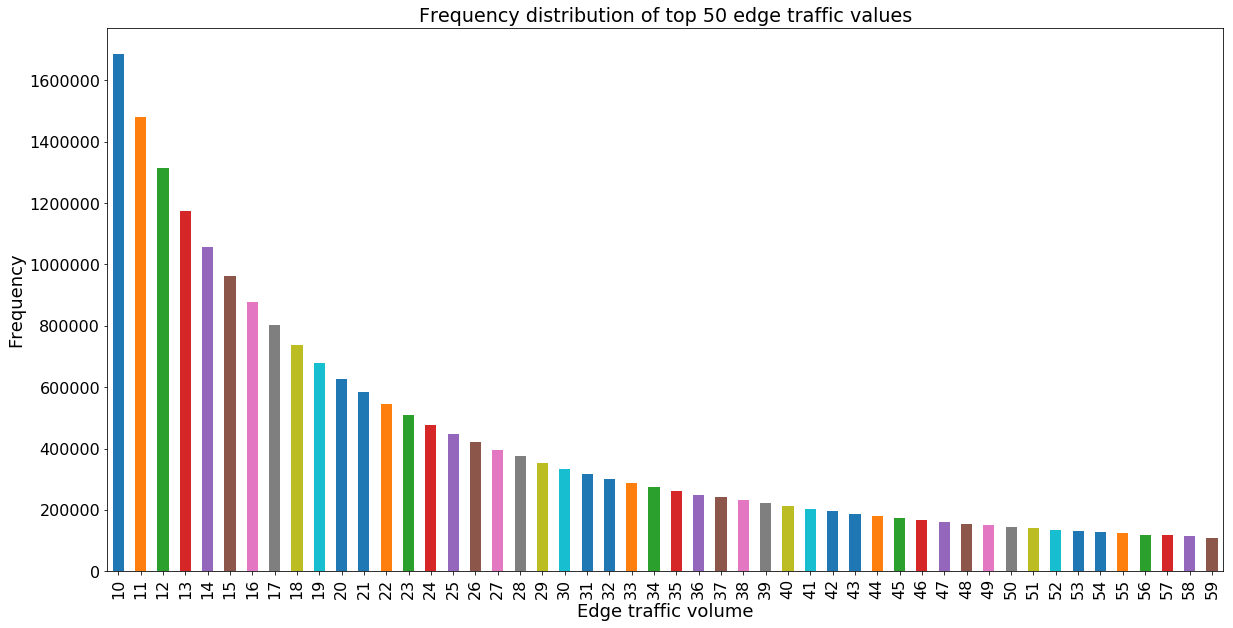

In [20]:
bar_chart = edge_traffic_frequencies.head(50).plot.bar(title="Frequency distribution of top 50 edge traffic values")
bar_chart.set_xlabel('Edge traffic volume', fontsize = 18)
bar_chart.set_ylabel('Frequency', fontsize = 18);

In [21]:
edge_traffic_rel_frequencies = edge_traffic_frequencies/len(df)

In [31]:
edge_traffic_rel_frequencies.values[:10]

array([0.05652721, 0.04960503, 0.04399119, 0.03934445, 0.03546021,
       0.03223332, 0.02937371, 0.02684831, 0.02471927, 0.02278809])

In [48]:
# Relative freq of edges with traffic volume of 20 or less
sum(edge_traffic_rel_frequencies.values[:11])

0.3819373575757186

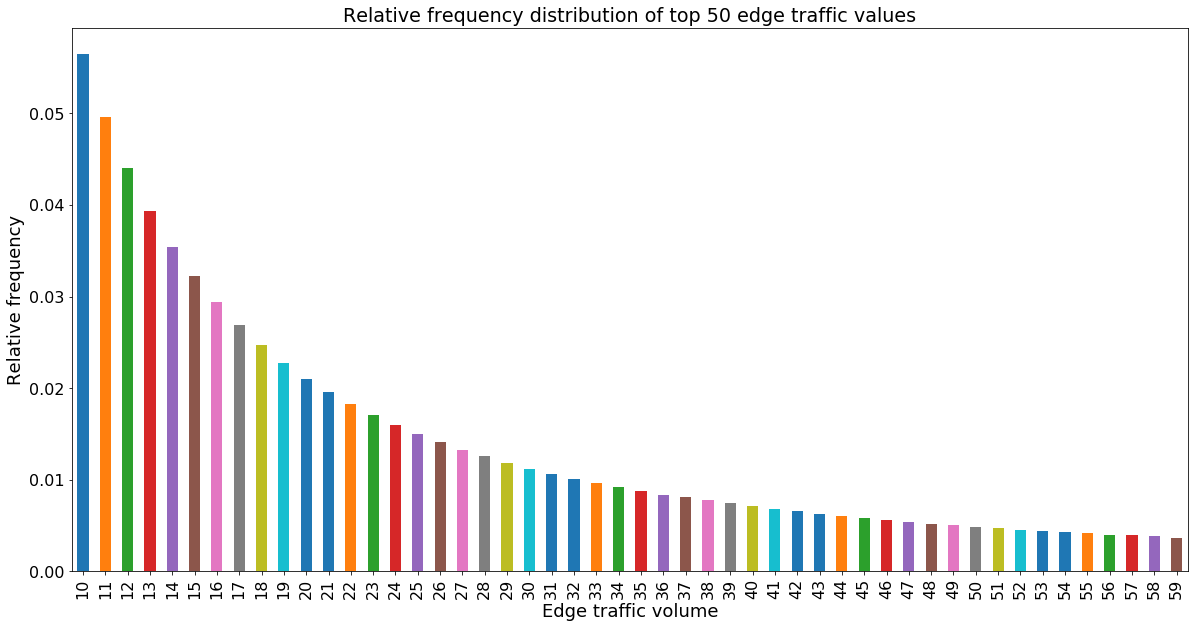

In [27]:
bar_chart = edge_traffic_rel_frequencies.head(50) \
    .plot.bar(title="Relative frequency distribution of top 50 edge traffic values")
bar_chart.set_xlabel('Edge traffic volume', fontsize = 18)
bar_chart.set_ylabel('Relative frequency', fontsize = 18);

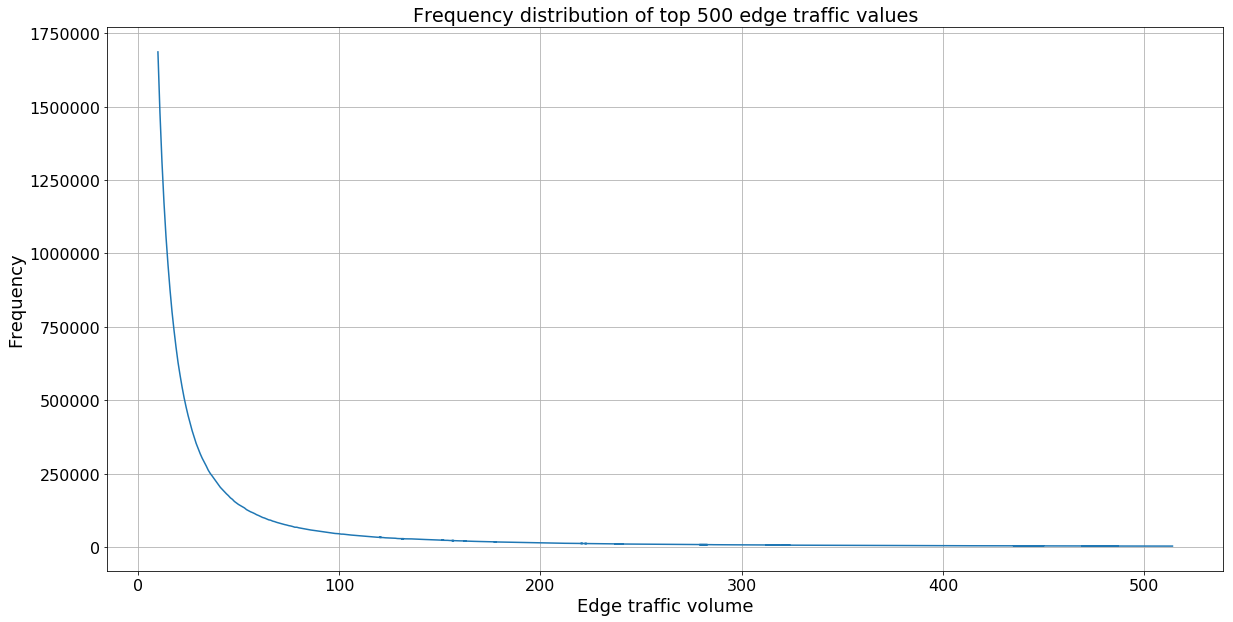

In [32]:
line_chart = edge_traffic_frequencies.head(500) \
    .plot.line(title="Frequency distribution of top 500 edge traffic values", grid=True)

line_chart.set_xlabel('Edge traffic volume', fontsize = 18)
line_chart.set_ylabel('Frequency', fontsize = 18);

In [105]:
edge_traffic_frequencies.describe()

count     42054
mean        710
std       19763
min           1
25%           1
50%           2
75%           9
max     1686994
Name: n, dtype: float64

In [106]:
len(edge_traffic_frequencies[edge_traffic_frequencies > 1])

24687

In [107]:
len(edge_traffic_frequencies[edge_traffic_frequencies == 1])

17367

In [108]:
edge_traffic_frequencies[24685:24695]

39728    2
16361    2
33170    1
48793    1
52480    1
35474    1
32804    1
32386    1
16776    1
68031    1
Name: n, dtype: int64

In [109]:
edge_traffic_frequencies[:10]

10    1686994
11    1480409
12    1312870
13    1174193
14    1058272
15     961969
16     876627
17     801259
18     737720
19     680086
Name: n, dtype: int64

In [110]:
edge_traffic_frequencies.head()

10    1686994
11    1480409
12    1312870
13    1174193
14    1058272
Name: n, dtype: int64

In [121]:
edge_traffic_frequencies.values[:10]

array([1686994, 1480409, 1312870, 1174193, 1058272,  961969,  876627,
        801259,  737720,  680086])

In [122]:
edge_traffic_frequencies.index.values[:10]

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

[Vsauce video on Zipf's law](https://www.youtube.com/watch?v=fCn8zs912OE)

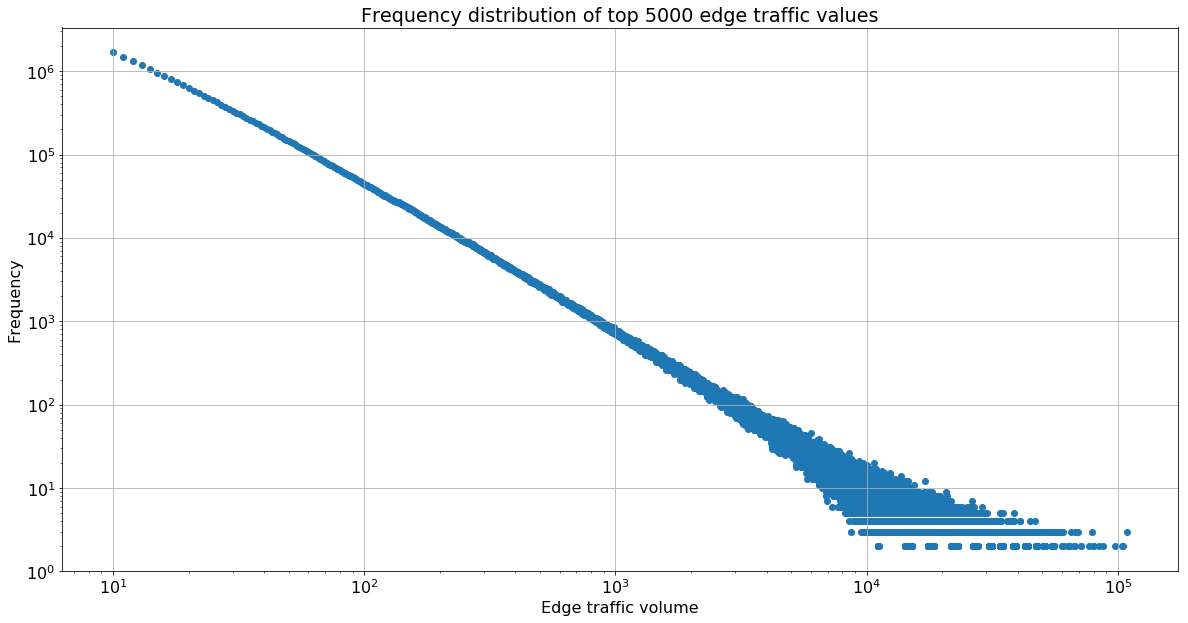

In [42]:
plt.scatter(edge_traffic_frequencies.index.values[:20000], edge_traffic_frequencies.values[:20000])
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of top 5000 edge traffic values");

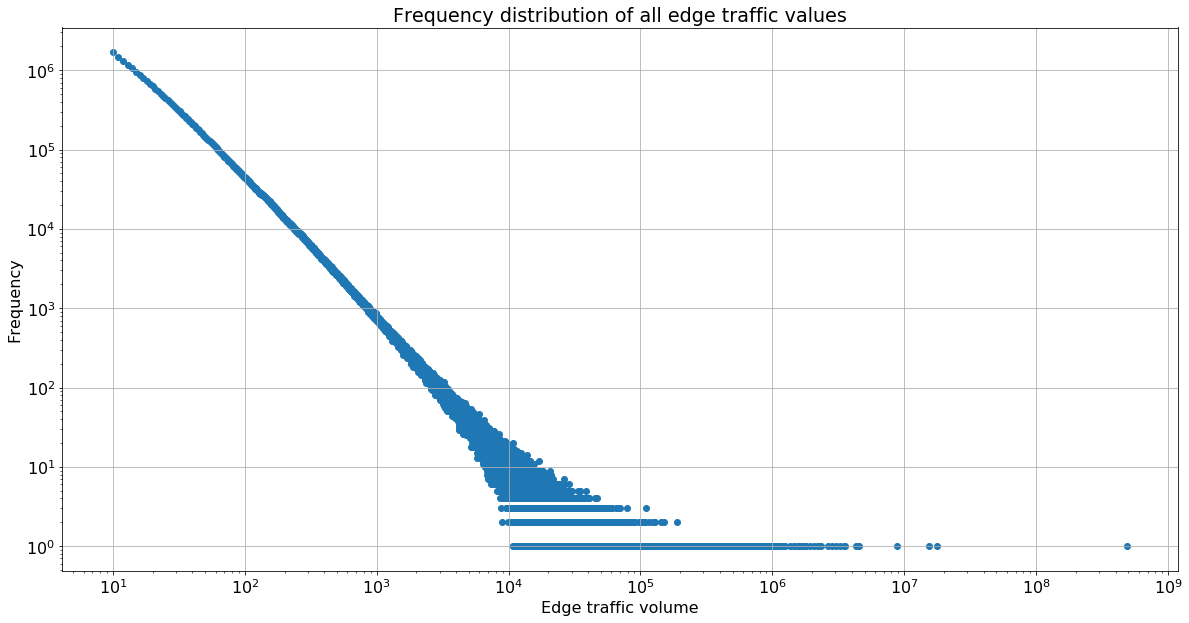

In [44]:
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of all edge traffic values");

In [53]:
import powerlaw

In [63]:
#data = edge_traffic_frequencies.values[:10000]
data = df["n"].values

In [64]:
# time this. Last run took about 30 min.
results = powerlaw.Fit(data)

Calculating best minimal value for power law fit
/Users/arina/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [65]:
print(results.power_law.alpha)
print(results.power_law.xmin)

2.7465478170902196
97984.0


In [66]:
R, p = results.distribution_compare('power_law', 'lognormal')

In [67]:
R

0.04186593354597434

In [68]:
p

0.544845625004867

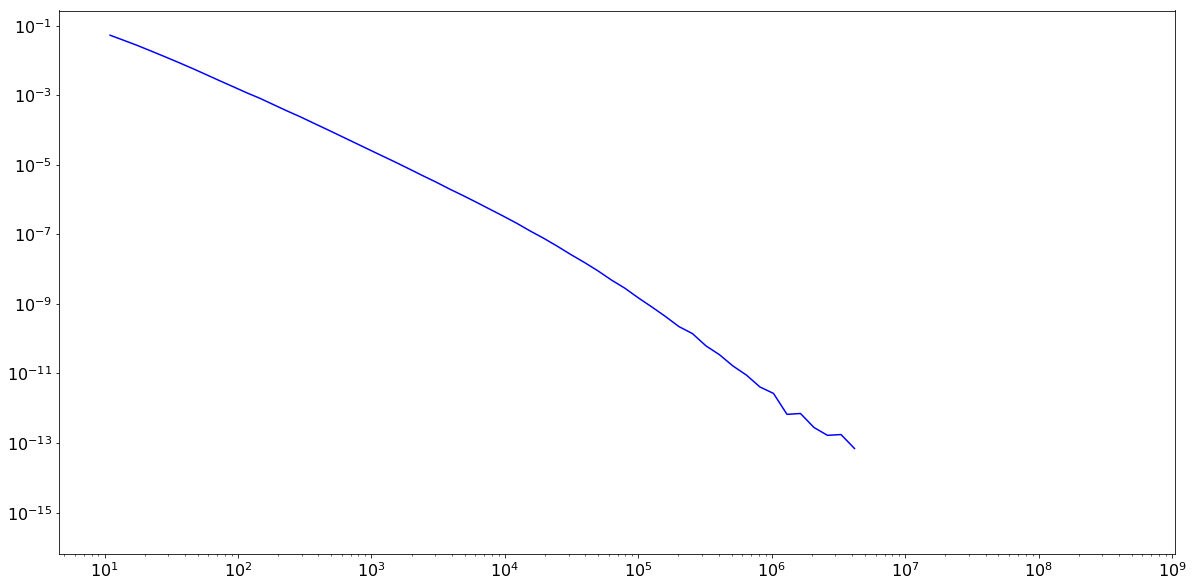

In [72]:
powerlaw.plot_pdf(data, color='b')

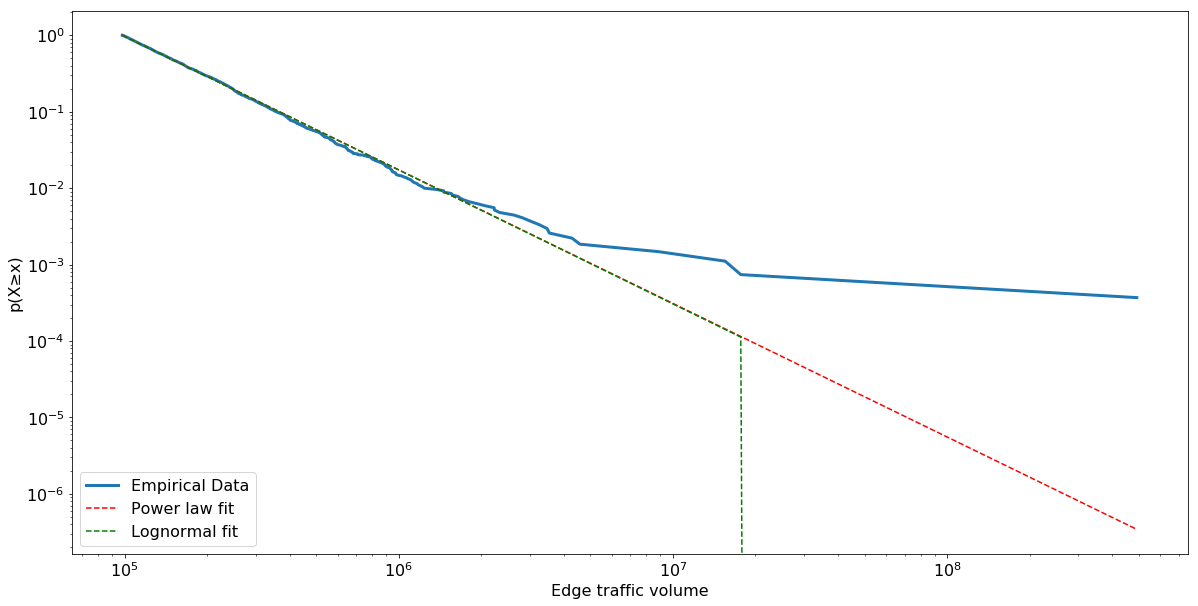

In [71]:

fig = results.plot_ccdf(linewidth=3, label='Empirical Data')
results.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
results.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("Edge traffic volume")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3);

In [24]:
df.groupby('curr').sum().sort_values('n', ascending=False)[:10]

,n
curr,
Main_Page,508992230
Hyphen-minus,42300873
George_H._W._Bush,6891439
Jason_Momoa,5261261
2.0_(film),4775391
Bird_Box_(film),4710338
XHamster,4354947
Aquaman_(film),3887205
Lists_of_deaths_by_year,3357694


In [25]:

clickstream = nx.DiGraph()

In [44]:
start_time = timer()
rows_total_count = len(df)

for i, row in df.iterrows():
    clickstream.add_edge(row['prev'], row['curr'], traffic = row['n'], link_type = row['type'])
    if i % 1000000 == 0:
        print(f'{round(i/rows_total_count * 100)}% done')
        print("elapsed time:", (timer() - start_time)/60, "min\n")
        
end_time = timer()


0% done
elapsed time: 0.1447992557666718 min

3% done
elapsed time: 1.5585065293499913 min

7% done
elapsed time: 3.004428672949992 min

10% done
elapsed time: 4.6194380532333374 min

13% done
elapsed time: 6.5980846082833375 min

17% done
elapsed time: 8.514604662500005 min

20% done
elapsed time: 10.367447325183337 min

23% done
elapsed time: 12.289904162466671 min

27% done
elapsed time: 14.295300761433328 min

30% done
elapsed time: 17.268469321966663 min

34% done
elapsed time: 19.47021953116667 min

37% done
elapsed time: 22.019473073716668 min

40% done
elapsed time: 24.102339129033332 min

44% done
elapsed time: 26.260862174333337 min

47% done
elapsed time: 28.20153869233333 min

50% done
elapsed time: 30.125884280433336 min

54% done
elapsed time: 32.094530061233336 min

57% done
elapsed time: 34.37006730806667 min

60% done
elapsed time: 36.96948394975001 min

64% done
elapsed time: 38.918416953716665 min

67% done
elapsed time: 40.89315858731667 min

70% done
elapsed time: 

In [45]:

print("add_edge total runtime:", (end_time - start_time)/60, "min\n")

add_edge total runtime: 66.51817008306666 min



In [53]:
clickstream.number_of_nodes()

5185321

In [57]:
start_time = timer()
pr = nx.pagerank(clickstream, alpha=0.9, weight = 'traffic')
end_time = timer()
print ("Runtime:", (end_time - start_time)/60, "min\n")

Runtime: 71.09349475370011 min



In [58]:
pr

{'other-empty': 1.3547285920117938e-07,
 '2019_Horizon_League_Baseball_Tournament': 1.3547286076148575e-07,
 'other-search': 1.3547285920117938e-07,
 'ForeverAtLast': 1.354728697786122e-07,
 'First_Families_of_Pakistan': 2.0683241786700676e-07,
 'Jehangir_Wadia': 2.8309350055981834e-07,
 'The_Lawrence_School,_Sanawar': 6.735126231197098e-07,
 'Wadia_family': 6.817899468542883e-07,
 'Ness_Wadia': 5.434117809234895e-07,
 'GoAir': 3.221213549944152e-07,
 'other-internal': 1.3547285920117938e-07,
 'Lovji_Nusserwanjee_Wadia': 1.902740674602411e-07,
 'Sangh_Parivar': 5.209159384942201e-07,
 'other-other': 1.3547285920117938e-07,
 'Parsi': 3.0008396254043805e-06,
 'Bombay_Dyeing': 1.8050202413646182e-07,
 'Wadia_Group': 4.7184095308030776e-07,
 'Dina_Wadia': 5.148782965399126e-07,
 'The_Age_of_Stupid': 5.103632187608094e-07,
 'other-external': 1.3547285920117938e-07,
 'Nusli_Wadia': 5.639474231832628e-07,
 'Neville_Wadia': 2.545217123874753e-07,
 'Metallate': 1.3547286497409683e-07,
 'Bob_Ham

In [63]:
start_time = timer()
pr2 = nx.pagerank_scipy(clickstream, alpha=0.9, weight = 'traffic')
end_time = timer()
print ("Runtime:", (end_time - start_time)/60, "min\n")

Runtime: 43.7223660145999 min

